# Exercise sheet 10

## NWO grant applications

### Exercise 1

For this exercise, you will need to load the dataset NWOGrants from the rethinking package. This dataset reports on the funding outcomes of the Netherlands Organisation for Scientific Research (NWO) grant applications over the 2010-2012 period. One study used that dataset to investigate gender bias in the funding awards: https://www.pnas.org/content/112/40/12349. You can read there that a response to this paper has been formulated, as briefly discussed at the beginning of lecture 9. Note that in general less than half applications are awarded funding.

Address the same question as the one in the paper by Lee and Ellemers by using binomial GLM to investigate potential gender bias on awards. Quantify the contrast between male and female applicants. In a second step, condition on the discipline as well. What are your conclusions? Should the NWO take specific measures for gender equity in general and across disciplines? Is there any excess variance in the data? If yes, can you elaborate on the nature of possible unaccounted sources?

In [1]:
library(rethinking)
data(NWOGrants)
d <- NWOGrants

Lade nötiges Paket: rstan

Lade nötiges Paket: StanHeaders


rstan version 2.26.16 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

Lade nötiges Paket: cmdstanr

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: D:/Users/Immanuel/Documents/.cmdstan/cmdstan-2.31.0

- CmdStan version: 2.31.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

Lade nötiges Paket: parallel

rethinking (Version 2.31)

In [2]:
d$male <- as.integer(d$gender) - 1
d$field <- as.integer(d$discipline)
d$accept <- d$awards / d$applications
d <- d[order(d$field), ]
d$accept.scaled <- scale(d$accept)
d

,discipline,gender,applications,awards,male,field,accept,accept.scaled
,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,"<dbl[,1]>"
1,Chemical sciences,m,83,22,1,1,0.2650602,1.41716126
2,Chemical sciences,f,39,10,0,1,0.2564103,1.25309407
13,Earth/life sciences,m,156,38,1,2,0.2435897,1.00992305
14,Earth/life sciences,f,126,18,0,2,0.1428571,-0.90070635
7,Humanities,m,230,33,1,3,0.1434783,-0.88892539
8,Humanities,f,166,32,0,3,0.1927711,0.04602831
11,Interdisciplinary,m,105,12,1,4,0.1142857,-1.44263033
12,Interdisciplinary,f,78,17,0,4,0.2179487,0.52358102
17,Medical sciences,m,245,46,1,5,0.1877551,-0.04911153


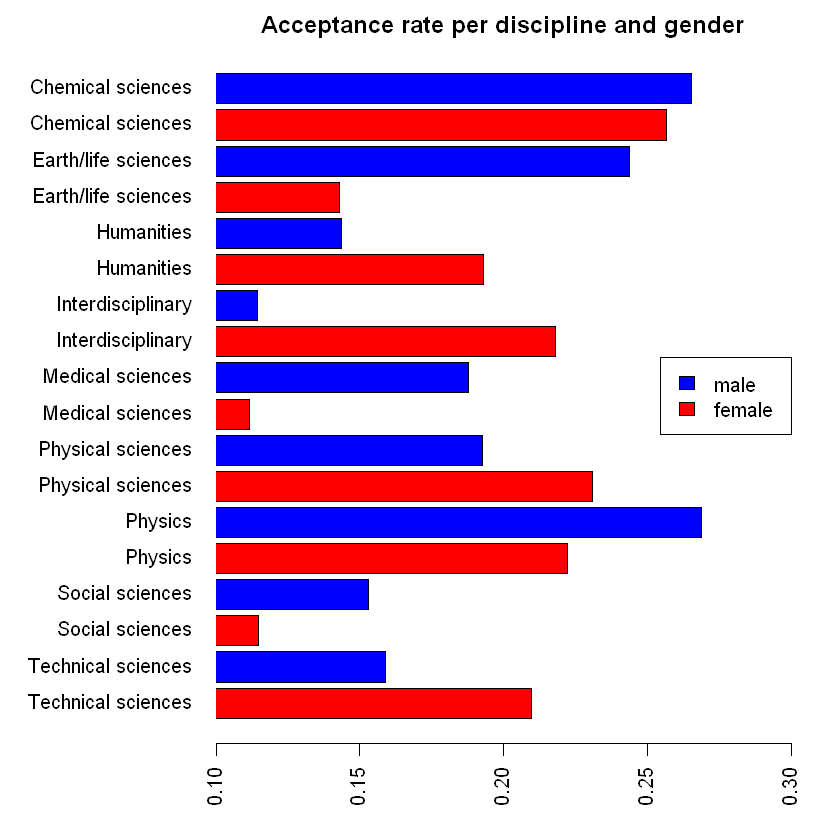

In [3]:
par(mar = c(4, 9, 2, 2))
barplot(rev(d$accept), names.arg = rev(d$discipline), las=2, xlim = c(0.10, 0.30), xpd = FALSE, horiz = TRUE, col = ifelse(d$male, "red", "blue"))
title("Acceptance rate per discipline and gender")
legend("right", c("male", "female"), fill = c("blue", "red"))

So male applicants are more likely to get accepted in humanities, interdiciplinary, physical and technical sciences. Female applicants are more likely to get accepted in chemical, earth/life, medical and social sciences and in physics.

In [4]:
e <- data.frame(discipline = character(), applications = integer(), awards = integer(), field = integer(), accept = double())
for (field in 1:max(d$field)) {
	dat <- d[d$field == field, ]
	discipline <- as.character(dat$discipline[1])
	applications <- sum(dat$applications)
	awards <- sum(dat$awards)
	accept <- awards / applications
	e[nrow(e) + 1, ] <- list(discipline, applications, awards, field, accept)
}
e

,discipline,applications,awards,field,accept
,<chr>,<int>,<int>,<int>,<dbl>
1,Chemical sciences,122,32,1,0.2622951
2,Earth/life sciences,282,56,2,0.1985816
3,Humanities,396,65,3,0.1641414
4,Interdisciplinary,183,29,4,0.1584699
5,Medical sciences,505,75,5,0.1485149
6,Physical sciences,174,35,6,0.2011494
7,Physics,76,20,7,0.2631579
8,Social sciences,834,112,8,0.1342926
9,Technical sciences,251,43,9,0.1713147


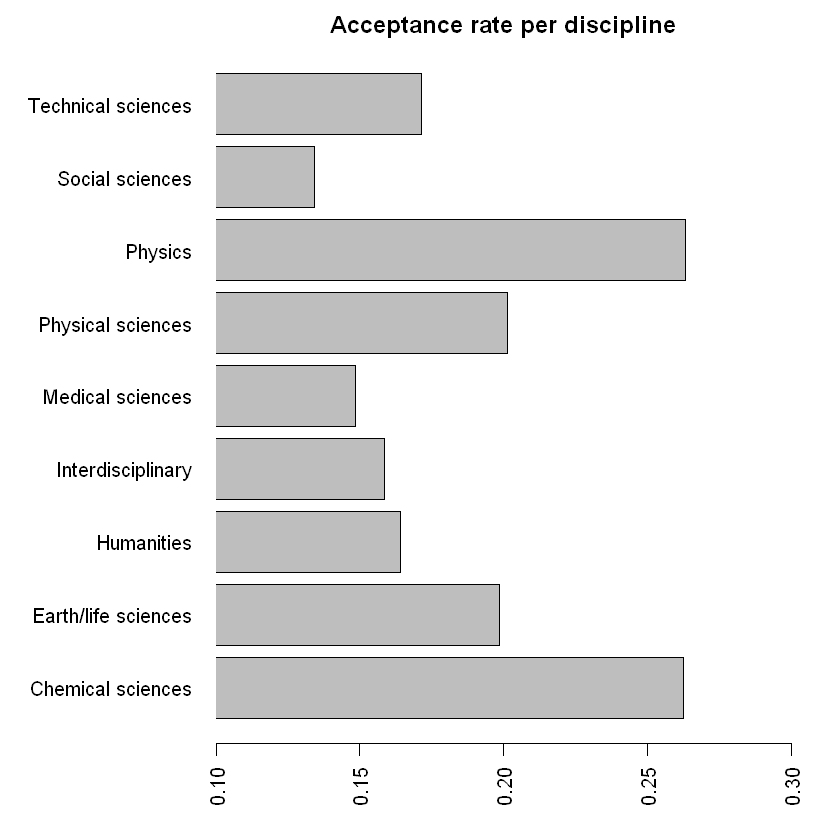

In [5]:
par(mar = c(4, 9, 2, 2))
barplot(e$accept, names.arg = e$discipline, las=2, xlim = c(0.10, 0.30), xpd = FALSE, horiz = TRUE)
title("Acceptance rate per discipline")

[1] 0.02838013

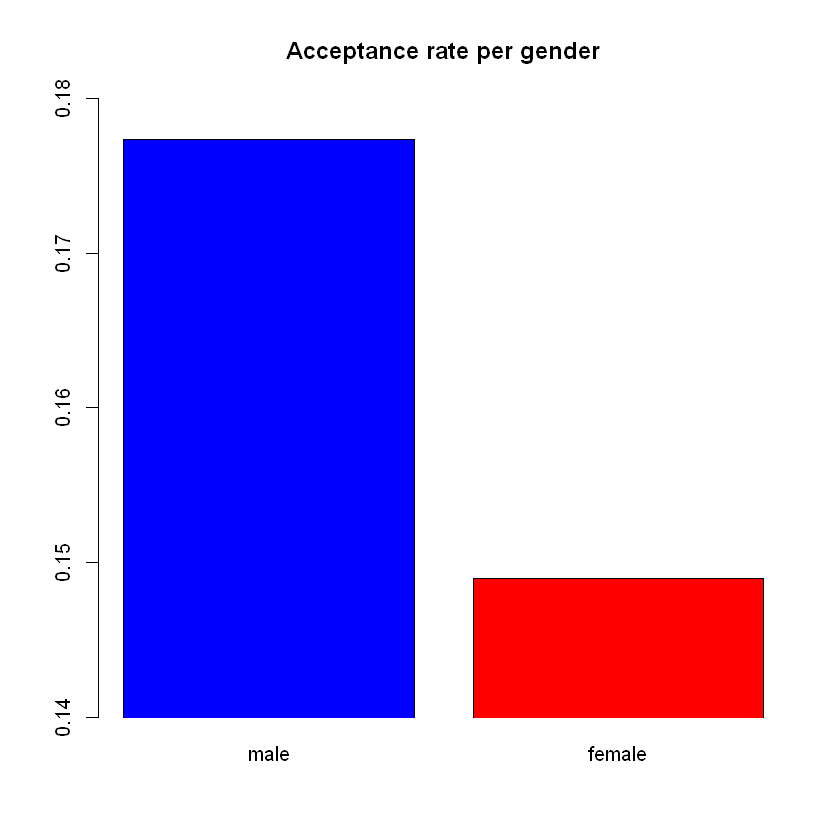

In [6]:
male_applications <- sum(d[d$male == 1, ]$applications)
female_applications <- sum(d[d$male == 0, ]$applications)
male_awards <- sum(d[d$male == 1, ]$awards)
female_awards <- sum(d[d$male == 0, ]$awards)
male_accept <- male_awards / male_applications
female_accept <- female_awards / female_applications

barplot(c(male_accept, female_accept), names.arg = c("male", "female"), ylim = c(0.14, 0.18), xpd = FALSE, col = c("blue", "red"))
title("Acceptance rate per gender")

mean(male_accept) - mean(female_accept)

So in the data there is a difference between the male and female acceptance rate in the data. But is it statistically significant? We construct different models and compare them.

In [7]:
# A single mean over all the data
model1 <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a,
		a ~ dnorm(0, 10)
	),
	data = d
)
model1_parameter_amount <- 1 # 1

In [8]:
# One mean for male and one mean for female
model_male <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a + a_male * male,
		a ~ dnorm(0, 10),
		a_male ~ dnorm(0, 10)
	),
	data = d
)
model_male_parameter_amount <- 1 + 1 # 2

In [9]:
# A model where we dont distinguish between male and female, but the department is relevant
model_field <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a[field],
		a[field] ~ dnorm(0, 10)
	),
	data = d
)
model_field_parameter_amount <- nrow(e) # 9

In [10]:
# Each field has its own mean but the change if a participant is male is global
model_field_male <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a[field] + a_male * male,
		a[field] ~ dnorm(0, 10),
		a_male ~ dnorm(0, 10)
	),
	data = d
)
model_field_male_parameter_amount <- nrow(e) + 1 # 10

In [11]:
# We have the same mean for all fields, but the influence if the participant is male is unique for each field
model_male_field <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a + a_male[field] * male,
		a ~ dnorm(0, 10),
		a_male[field] ~ dnorm(0, 10)
	),
	data = d
)
model_male_field_parameter_amount <- 1 + nrow(e) # 10

In [12]:
# Both the mean and the offset for a male participant is different for each department
model_field_male_field <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a[field] + a_male[field] * male,
		a[field] ~ dnorm(0, 10),
		a_male[field] ~ dnorm(0, 10)
	),
	data = d
)
model6_field_male_field_parameter_amount <- nrow(e) + nrow(e) # 18

In [13]:
compare(model1, model_male, model_field, model_field_male, model_male_field, model_field_male_field)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model_field_male_field,115.7915,3.157655,0.000000,NA,9.631197,0.9610414407
model_male_field,122.5536,7.439860,6.762134,5.931200,7.417447,0.0326861140
model_field,127.2502,9.104048,11.458688,7.312357,11.513816,0.0031226232
model_field_male,128.6600,8.059377,12.868567,6.444309,12.687967,0.0015430084
model_male,129.5456,8.728624,13.754108,7.504840,4.648225,0.0009910041
model1,130.4971,12.936419,14.705670,12.085615,2.905528,0.0006158096


So we see that the model that is able to distinguish between male and female and also between departments is able to fit the data the best, obviously.

Now we quantify the contrast while disregarding the field the participants come from. These are the two models ```model_male``` and ```model1```. Because the latter is gender independent, we only have to do this discussion one for the first model.

In [14]:
# The relative scale, which in most cases can be disregarded.
summary(model1)
summary(model_male)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-1.61835,0.05065213,-1.699302,-1.537398


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-1.7424162,0.08146995,-1.87262090,-1.6122115
a_male,0.2081391,0.10405967,0.04183164,0.3744465


In [15]:
# Better to compare the models with an information criterion
compare(model1, model_male)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model_male,129.5348,8.791674,0.0000000,NA,4.636433,0.6101221
model1,130.4305,13.061795,0.8956508,6.515686,2.840859,0.3898779


We see that the inclusion of the male parameter makes a difference, although its not that significant. Next we look at the contrast between the number of male and female awardees in the second model.

In [16]:
post <- extract.samples(model_male)
p.award.male <- logistic(post$a + post$a_male)
p.award.female <- logistic(post$a)
diff.award <- p.award.male - p.award.female
quantile(diff.award, c(0.025, 0.5, 0.975))

2.5%          50%        97.5% 
0.0002806522 0.0284697162 0.0553008686

We see that as in the data, the model generated a gap between male and female of 0.028, which means that males are 3 percent more likely to be awarded than females. Next we also include the field of study. We consider the model ```model_field_male_field```.

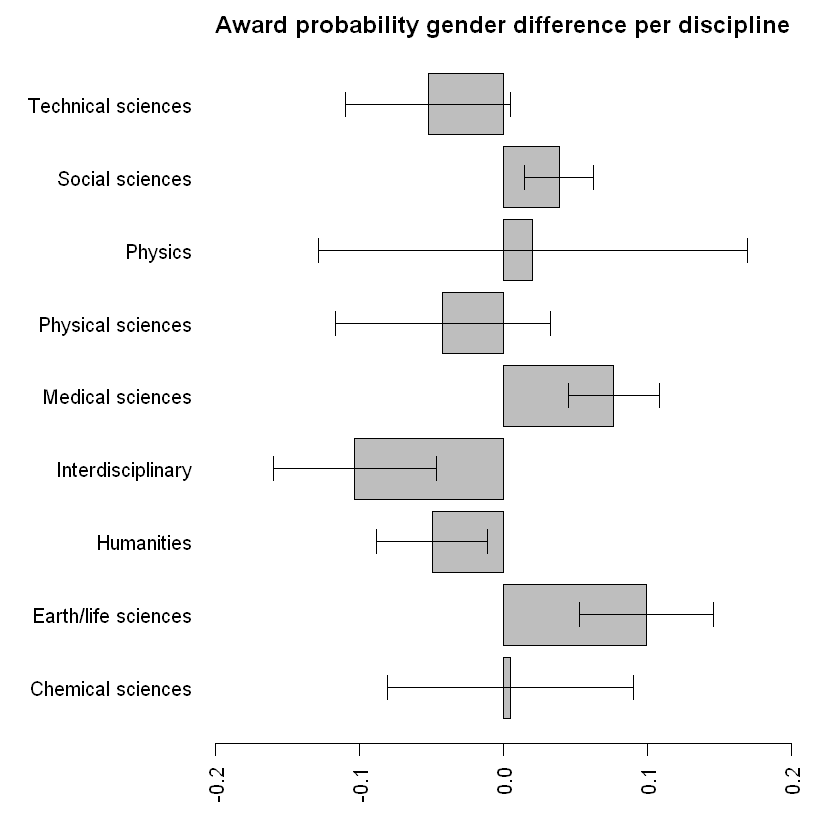

In [21]:
post <- extract.samples(model_field_male_field)
p.award.male <- logistic(post$a + post$a_male)
p.award.female <- logistic(post$a)
diff.award <- p.award.male - p.award.female

means <- c()
stds <- c()
names <- c()
for (index in 1:ncol(diff.award)) {
	means <- append(means, mean(diff.award[, index]))
	stds <- append(stds, sd(diff.award[, index]))
	names <- append(names, e[e$field == index, ]$discipline)
}

scale <- 1.2
offset <- 0.5

par(mar = c(4, 9, 2, 2))
bp <- barplot(means, names.arg = names, las=2, xpd = FALSE, horiz = TRUE, xlim = c(-0.2, 0.2))
arrows(means+stds, (1:9) * scale - offset, means-stds, (1:9) * scale - offset, angle = 90, code = 3, length = 0.1, col = "black")
title("Award probability gender difference per discipline")